In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.figure_factory as ff
import plotly.express as px
from collections import Counter
import plotly.express as px
from nltk import ngrams
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv


In [2]:
train = pd.read_csv("../input/tweet-sentiment-extraction/train.csv")
test = pd.read_csv("../input/tweet-sentiment-extraction/test.csv")
sent = train['sentiment'].unique()

print(train.shape,
      test.shape)

(27481, 4) (3534, 3)


In [3]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
train['text'] = train['text'].fillna('')
train['selected_text'] = train['selected_text'].fillna('')
train['text'] = train['text'].str.lower()

# Exploratory Data Analysis

### Null values
We observe if there are any empty strings and what sentiment is assigned to it.

In [5]:
train[train['text'].isna()]

,textID,text,selected_text,sentiment


### Length of tweets
We inspect the length of tweets by sentiments

In [6]:

vals = [train['text'][train['sentiment']==s].str.len() for s in sent]

fig = ff.create_distplot(vals, sent,show_hist=False)
fig.update_layout(title="Distribution of length of tweets")
fig.show()

### Number of words
We inspect the number of words by sentiments

In [7]:
vals = [train['text'][train['sentiment']==s].str.split().map(len) for s in sent]

fig = ff.create_distplot(vals, sent,show_hist=False)
fig.update_layout(title="Distribution of number of words")
fig.show()

All 3 classes seem to have pretty similar distributon of words/length of text

### Ratio of selected text over text

We can observe that for negative and positive sentiments, they have a higher ratio than neutral sentiments - which can go as high as 1 (selected text is wholly extracted from text) 
Hence, we may include this as a feature for the model as it is a discriminative feature.

In [21]:
train['ratio'] = train['selected_text'].str.len()/train['text'].str.len()
train['ratio'] = train['ratio'].fillna(0)
vals = [train['ratio'][train['sentiment']==s] for s in sent]

fig = ff.create_distplot(vals, sent,show_hist=False)
fig.update_layout(title="Distribution of ratio of length of selected text over text")
fig.show()

In [9]:
def get_topwords(text):
    return Counter(" ".join(text).split()).most_common(20)

for s in sent:
    vals = get_topwords(train["text"][train['sentiment']==s])
    fig = px.bar(pd.DataFrame(vals,columns=['Word','Count']) ,x='Word', y='Count',title='Popular uni-grams for sentiment:'+s)
    fig.show()

### Get popular bigrams

In [10]:
#Do one for selected text too
for s in sent:
    vals = get_topwords([word[0]+'_'+word[1] for sent in train["text"][train['sentiment']==s].str.split().apply(ngrams ,n=2) for word in sent])
    fig = px.bar(pd.DataFrame(vals,columns=['Word','Count']) ,x='Word', y='Count',title='Popular bi-grams for sentiment: '+s)
    fig.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning:

generator 'ngrams' raised StopIteration



### Unique words

In [11]:
#Do one for selected text too
def get_uniquewords(text):
    return text.str.split().apply(set).apply(len).sum()


vals = [get_uniquewords(train["text"][train['sentiment']==s]) for s in sent]
fig = px.bar(vals,title='Popular uni-grams by sentiment')
fig.show()

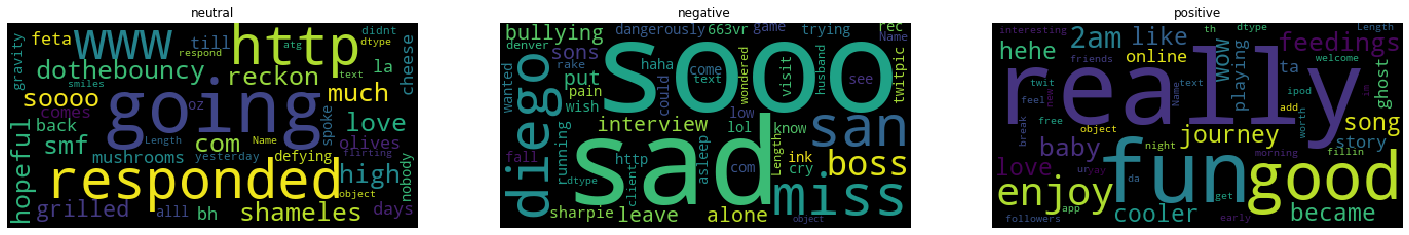

In [12]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

stopwords = set(stopwords.words('english'))

def plot_words(data, title = None,ax=None,s=None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords
        )
    
    wordcloud=wordcloud.generate(str(data))
    ax.imshow(wordcloud,interpolation='nearest')
    ax.axis('off')
    ax.set_title(s)

fig,ax=plt.subplots(1,3,figsize=(25,15))
vals = [train[train['sentiment']==s]['text'] for s in sent]
plot_var = [plot_words(val,ax=ax[ind],s=sent[ind]) for ind,val in enumerate(vals)]    

#### Look at common words for selected text

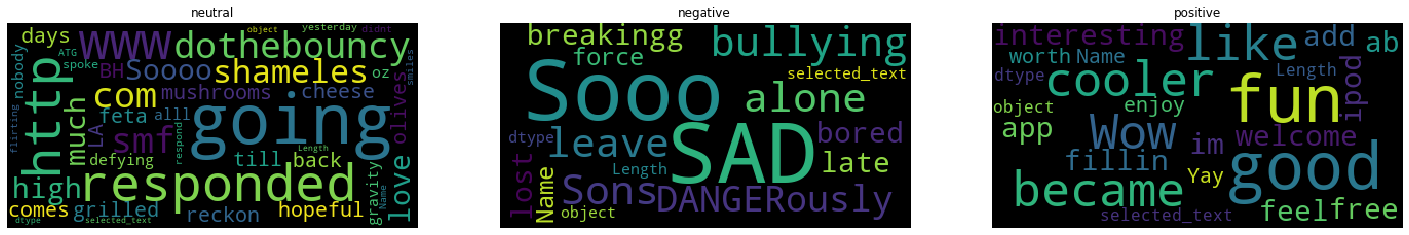

In [13]:
fig,ax=plt.subplots(1,3,figsize=(25,15))
vals = [train[train['sentiment']==s]['selected_text'] for s in sent]
plot_var = [plot_words(val,ax=ax[ind],s=sent[ind]) for ind,val in enumerate(vals)]    

One unusual observation is that words like 'www' and 'http', which are part of links, shows up in our word cloud. This means that the labelled data considers links to be part of the selected text and they are possibly sandwiched between words, which makes them part of the selected text. Hence, we shall look at tweets containing links and observe how many of them belong to which sentiments - this gives us a good idea whether tweets containing links are a good discriminative feature.

In [14]:
import re

pattern = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
train['text_urls'] = train['text'].str.findall(pattern).map(len)
train['selectedtext_urls'] = train['selected_text'].str.findall(pattern).map(len)

### Look at how many urls are there among the sentiments (text)

There are alot more links in tweets with neutral sentiments, while negative sentiments have lesser tweets. Also, we can ntoe that there can have more than 1 link per tweet.

In [15]:
import plotly.graph_objects as go

x = train['sentiment'][train['text_urls']>0]
y = train['text_urls'][train['text_urls']>0]

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=y, x=x, name="count"))
fig.add_trace(go.Histogram(histfunc="sum", y=y, x=x, name="sum"))

fig.show()

### Look at how many urls are there among the sentiments (selected text)

And interestingly, there are many neutral tweets that have links appearing in the selected text labels compared to negative or positive labels.

In [16]:
x = train['sentiment'][train['selectedtext_urls']>0]
y = train['text_urls'][train['selectedtext_urls']>0]

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=y, x=x, name="count"))
fig.add_trace(go.Histogram(histfunc="sum", y=y, x=x, name="sum"))

fig.show()

Lets take a look at some of these tweets. We can see that for neutral tweets, they usually have a high ratio (percentage of text being selected for 'selected text' label) 
It may be due to the characters of the links that adds to the neutrality of the tweet.

As for positive and negative tweets, there are only 5 of them, and do not seem to have any interesting information.

In [17]:
train[['text','ratio']][(train['selectedtext_urls']>0) & (train['sentiment']=='neutral')]

,text,ratio
5,http://www.dothebouncy.com/smf - some shameles...,1.000000
50,then you should check out http://twittersucks...,0.989796
215,yellow for ? http://blip.fm/~5z05g,1.000000
258,here are 4 free twitter tools will get you fol...,1.000000
341,"it`s a peter & gordon morning -> and i, go to...",1.000000
...,...,...
27168,http://twitpic.com/2xjoc - can you paint me,0.977273
27170,if you hit a car .. u should leave a note http...,1.000000
27231,just finished watching my copy of the twilight...,1.000000
27282,from last montday`s award ceremony http://twi...,1.000000


In [18]:
train['selected_text'][(train['selectedtext_urls']>0) & (train['sentiment']=='positive')].values

array(["awwww..... thought it`d be a 'yummy' experience.  Will try it next time",
       'wants see my friends  ;-) http://plurk.com/p/wxnwa',
       'Lindsay we are your spanish fansite and we love you www.ultimatelohan.org please reply us  I wish you a good flight <3',
       'add me up: http://profiles.friendster.com/americanidolislove  friendster.',
       'Feel I`ve got a real bargain from http://www.laskys.com  ï¿½80 cheaper than the place I almost used.'],
      dtype=object)

In [19]:
train['selected_text'][(train['selectedtext_urls']>0) & (train['sentiment']=='negative')].values

array(['This song is a slap on you face!!  ? http://blip.fm/~5jib6',
       'http://twitpic.com/674p1 -  this is my Ohio is for lovers tattoo got the design off the shirt.. haha but I lost the shirt',
       'This is not what I thought will eventually happen in my 6th grade  Awww...bad, bad',
       'Daddy just left.................without me  http://yfrog.com/13pdrmj'],
      dtype=object)